# FRB optical counterpart simulation

This notebook breaks down the simulation of a Fast Radio Bursts (FRB) optical counterpart in the Vera C. Rubin Observatory system. It starts with a simulation of a Sersic FRB of 5ms in a galaxy (bulge + disk) observed for 15s. The photons are simulated through the atmosphere and the telescope system using Batoid and GalSim packages. The results show the same galaxy with and without the effect of an FRB.

Import relevant python packages:

In [1]:

import batoid
import galsim
import matplotlib.pyplot as plt
import numpy as np
import pickle
import traced




In [2]:
pwd

'/home/guillemmh/fob-simulation'

## 1. Initialization of variables

Set initial variables and constants for the simulation.

In [3]:
# Some settings here.
SEEING_FACTOR = 1.0  # Knob to dial seeing up or down
PIXEL_SIZE = 10e-6
STAMP_SIZE = 10
SKY_LEVEL = 1000.0
DEFOCUS = 0.0015
M2_ALIGNMENT = 1.0
CAMERA_ALIGNMENT = 1.0
M1M3_BEND = 1.0
M2_BEND = 1.0
SHOW = True
SAVE_PHOTONS = False
NPHOTON = int(8e6)
NSTAR = 1
SIMPLIFY = False

# Define wavelength dictionary
wavelength_dict = dict(
    u = 365.49,
    g = 480.03,
    r = 622.20,
    i = 754.06,
    z = 868.21,
    y = 991.66
)

# Define the observation parameters.
observation = {
    'boresight': galsim.CelestialCoord(
        30*galsim.degrees, 10*galsim.degrees
    ),
    'zenith': 30*galsim.degrees,
    'airmass': 1.1547,
    'rotTelPos': 0.0*galsim.degrees,  # zenith measured CCW from up
    'rotSkyPos': 0.0*galsim.degrees,  # N measured CCW from up
    'rawSeeing': 0.7*galsim.arcsec,
    'band': 'i',
    'exptime': 15.0,
    'frbtime': 0.005,
    'temperature': 293.15,  # K
    'pressure': 69.328,  # kPa
    'H2O_pressure': 1.067,  # kPa
}

# Set the wavelenght from the observation band. 
wavelength = wavelength_dict[observation['band']]
rng = galsim.BaseDeviate(577)

# Load atmosphere phase screen list created from Elleboerk model.
with open("/home/guillemmh/fob-simulation/policy/full_atm.pkl", 'rb') as f:
    full_atm = pickle.load(f)



In [ ]:
rng = galsim.BaseDeviate(57)
traced_photons, wavelengths = traced.tracePhotons(int(7.5e5), rng, observation, wavelength, full_atm, 0.015)

image_array = traced.generateImage(traced_photons, wavelengths, STAMP_SIZE, PIXEL_SIZE, SKY_LEVEL, noise = False)

plt.imshow(image_array)
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 26)

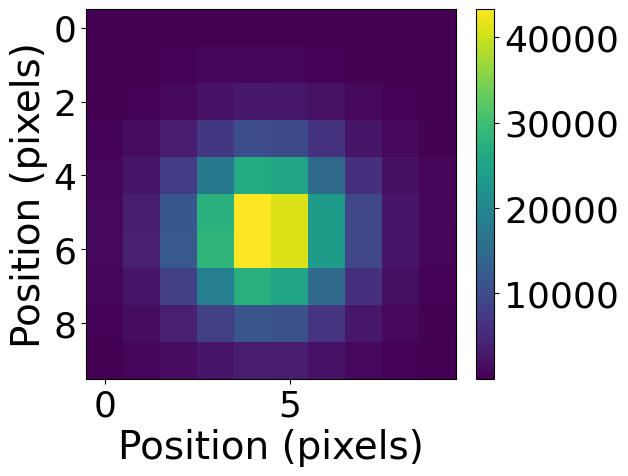

In [6]:
traced_photons, wavelengths = traced.tracePhotons(int(7.5e5), rng, observation, wavelength, full_atm, 15)

image_array = traced.printSensorImage(traced_photons, wavelengths, STAMP_SIZE, PIXEL_SIZE, SKY_LEVEL, noise = False)

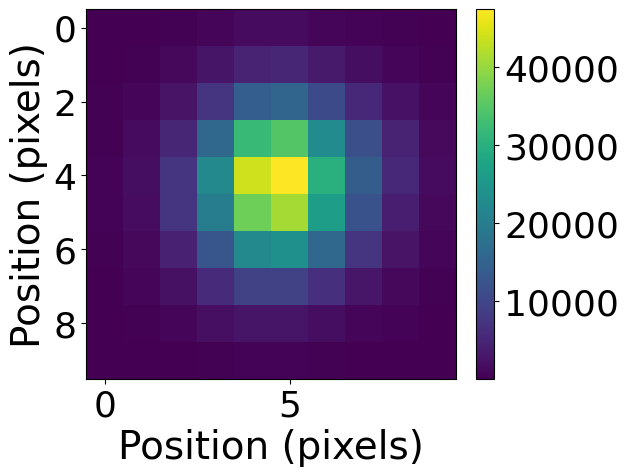

In [5]:
traced_photons, wavelengths = traced.tracePhotons(int(7.5e5), rng, observation, wavelength, full_atm, 0.15)

image_array = traced.printSensorImage(traced_photons, wavelengths, STAMP_SIZE, PIXEL_SIZE, SKY_LEVEL, noise = False)

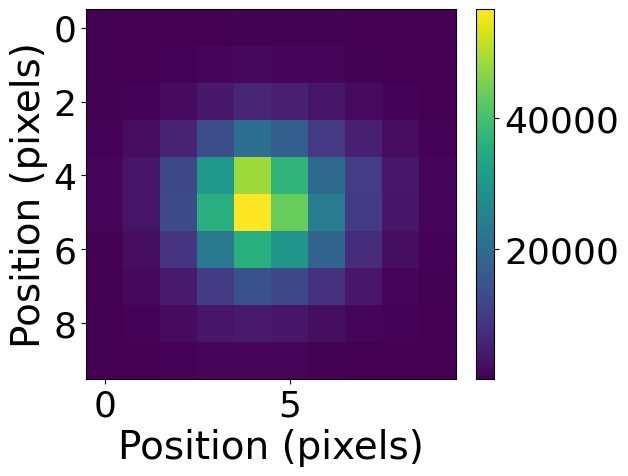

In [4]:
traced_photons, wavelengths = traced.tracePhotons(int(7.5e5), rng, observation, wavelength, full_atm, 0.015)

image_array = traced.printSensorImage(traced_photons, wavelengths, STAMP_SIZE, PIXEL_SIZE, SKY_LEVEL, noise = False)

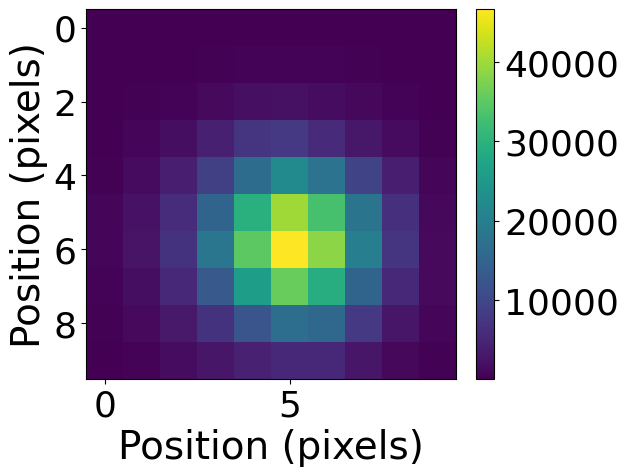

In [5]:
traced_photons, wavelengths = traced.tracePhotons(int(7.5e5), rng, observation, wavelength, full_atm, 0.015)

image_array = traced.printSensorImage(traced_photons, wavelengths, STAMP_SIZE, PIXEL_SIZE, SKY_LEVEL, noise = False)

In [5]:

def plot_results(traced_photons, title, rng):
    fig = plt.figure(figsize=(27, 8))
    plt.subplot(1, 2, 1)
    star_array = printSensorImage(
        traced_photons, 
        wavelengths, 
        STAMP_SIZE = 15, 
        PIXEL_SIZE = 10e-6,
        SKY_LEVEL = 1000.0,
        noise = False,
    )

    print(sum(sum(star_array)))
    

    plt.title(title, fontsize = 30)

    plt.subplot(1, 3, 2)
    star_array = trace.printSensorImage(
        traced_photons, 
        wavelengths, 
        STAMP_SIZE = 30, 
        PIXEL_SIZE = 50e-7,
        SKY_LEVEL = 1000.0,
        noise = False,
    )


    plt.title(title + ' - $5 \mu/pixel$', fontsize = 30)

    plt.subplot(1, 2, 2)
    star_array = printSensorImage(
        traced_photons, 
        wavelengths, 
        STAMP_SIZE = 150, 
        PIXEL_SIZE = 10e-7,
        SKY_LEVEL = 1000.0,
        noise = False,
    )


    plt.title(title + ' - $1 \mu/pixel$', fontsize = 30)
    fig.tight_layout(pad=2)


In [8]:
from tqdm.notebook import trange, tqdm
intensities = [750000]
durations = [0.015, 0.15]

rng = galsim.BaseDeviate(59)

for intens in intensities:
    
    for duration in tqdm(durations): 

        # Define FRB as a delta function profile.
        frb_delta = galsim.DeltaFunction(flux = 3e5)

        # Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
        frb_atm_psf = full_atm.makePSF(
                    wavelength, 
                    diam = 8.36,
                    exptime = duration, 
                    t0 = 0.92,
                    flux = 1.0, 
                    geometric_shooting = False,
                    second_kick = False,
                )

        # Convolve with point-source psf
        frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])
        frb_photons = frb_total_psf.shoot(int(intens), rng)
        traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

        image_array = getArray(
            traced_photons, 
            wavelengths, 
            STAMP_SIZE = 15, 
            PIXEL_SIZE = 10e-6,
            SKY_LEVEL = 1000.0,
            noise = False,
        )
        np.save(f'fob_instance_{duration}s_{intens}_res1_effect', image_array)
        
        
        image_array = getArray(
            traced_photons, 
            wavelengths, 
            STAMP_SIZE = 30, 
            PIXEL_SIZE = 50e-7,
            SKY_LEVEL = 1000.0,
            noise = False,
        )
        np.save(f'fob_instance_{duration}s_{intens}_5mu_effect', image_array)
        
        image_array = getArray(
            traced_photons, 
            wavelengths, 
            STAMP_SIZE = 150, 
            PIXEL_SIZE = 10e-7,
            SKY_LEVEL = 1000.0,
            noise = False,
        )
        np.save(f'fob_instance_{duration}s_{intens}_1mu_effect', image_array)


  0%|          | 0/3 [00:00<?, ?it/s]

-1
16
0
17
(15, 15)
(1, 15)


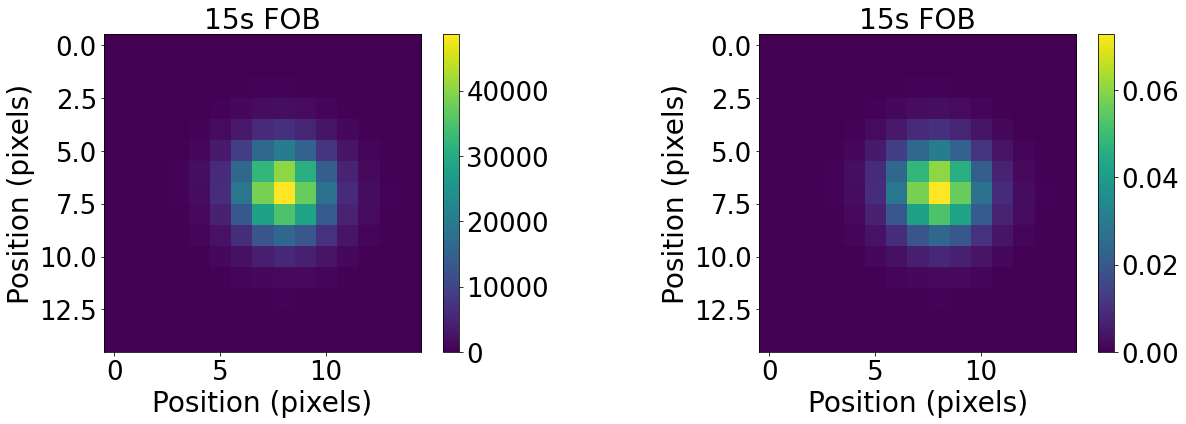

In [20]:

image_array = normalize(star_array2)
print(image.shape)
    
    
plt.figure(figsize = (18, 6))
plt.subplot(1,2,1)
plt.imshow(star_array2)
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('15s FOB', fontsize = 28)
cbar.ax.tick_params(labelsize = 26)

plt.subplot(1,2,2)
plt.imshow(image_array)
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('15s FOB', fontsize = 28)
cbar.ax.tick_params(labelsize = 26)
plt.tight_layout()

In [15]:
print(star_array2.shape)

(15, 15)


In [ ]:
%%time 
rng = galsim.BaseDeviate(49)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            diam = 8.36,
            exptime = 15, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )
# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])
frb_photons = frb_total_psf.shoot(int(7.5e5), rng)
traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

star_array1 = getArray(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 15, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = False,
)


CPU times: user 3min 10s, sys: 563 ms, total: 3min 11s
Wall time: 3min 6s


In [ ]:

plt.figure(figsize = (18, 6))
plt.subplot(1,2,1)
plt.imshow(normalize(star_array1))
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('15s FOB', fontsize = 28)
cbar.ax.tick_params(labelsize = 26)

plt.subplot(1,2,2)
plt.imshow(abs(normalize(star_array1) - normalize(star_array2)))
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.title('Difference', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 26)
plt.tight_layout()

In [55]:
rng = galsim.BaseDeviate(542)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )
# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])
frb_photons = frb_total_psf.shoot(int(7.5e5), rng)
traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

star_array3 = getArray(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 15, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = False,
)


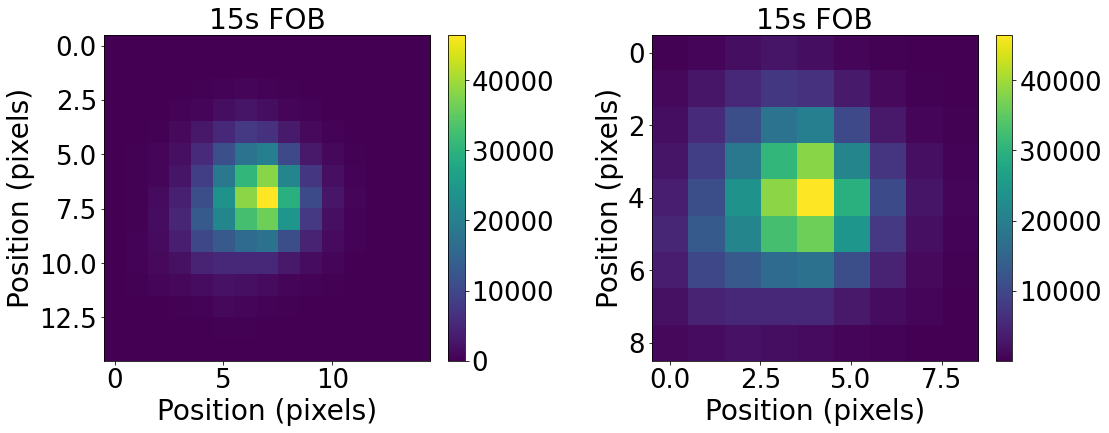

In [72]:
image = star_array3
cy, cx = ndi.center_of_mass(image)

cmy, cmx = np.where(image == np.max(image))
cy = cmy[0]
cx = cmx[0]
image = image[int(np.round(cy)) - 4 : int(np.round(cy)) + 4 + 1, int(np.round(cx)) - 4 : int(np.round(cx)) + 4 + 1]
image_array = image/sum(sum(image))
    
    
plt.figure(figsize = (18, 6))
plt.subplot(1,2,1)
plt.imshow(star_array3)
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('15s FOB', fontsize = 28)
cbar.ax.tick_params(labelsize = 26)

plt.subplot(1,2,2)
plt.imshow(image)
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('15s FOB', fontsize = 28)
cbar.ax.tick_params(labelsize = 26)

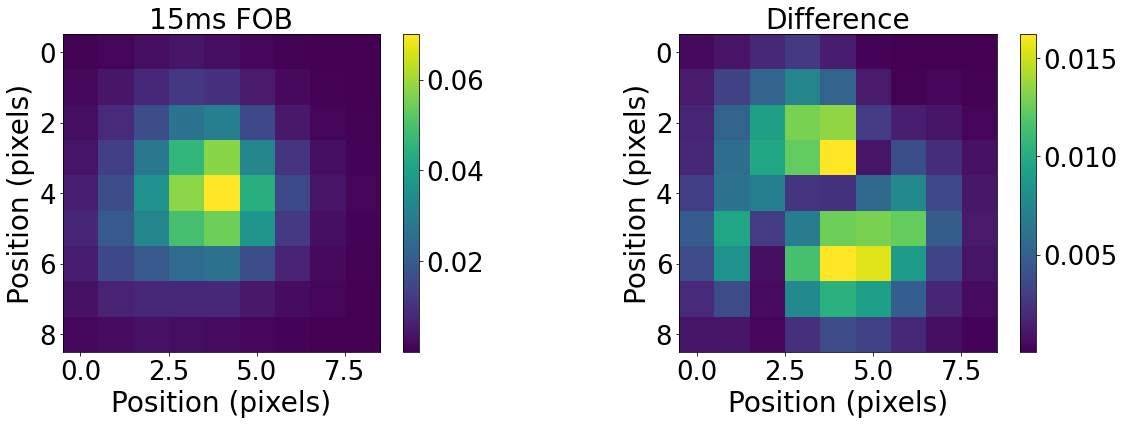

In [76]:


plt.figure(figsize = (18, 6))
plt.subplot(1,2,1)
plt.imshow(normalize(star_array3))
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
plt.title('15ms FOB', fontsize = 28)
cbar.ax.tick_params(labelsize = 26)

plt.subplot(1,2,2)
plt.imshow(abs(normalize(star_array3) - normalize(star_array2)))
plt.xlabel('Position (pixels)', fontsize = 28)
plt.ylabel('Position (pixels)', fontsize = 28)
plt.title('Difference', fontsize = 28)
plt.tick_params(labelsize = 26)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 26)
plt.tight_layout()

### Intensity comparison

In [11]:
import time
def test_resume():
    """Test that the resume option for accumulate works properly.
    """
    # Note: This test is based on a script devel/lsst/treering_skybg_check.py

    rng = galsim.UniformDeviate(314159)

    if __name__ == "__main__":
        flux_per_pixel = 40
        nx = 200
        ny = 200
        block_size = int(1.2e5)
        nrecalc = 1.e6
    else:
        flux_per_pixel = 40
        nx = 20
        ny = 20
        block_size = int(1.3e3)
        nrecalc = 1.e4

    expected_num_photons = nx * ny * flux_per_pixel
    pd = galsim.PoissonDeviate(rng, mean=expected_num_photons)
    num_photons = int(pd())  # Poisson realization of the given expected number of photons.
    #nrecalc = num_photons / 2  # Only recalc once.
    flux_per_photon = 1
    print('num_photons = ',num_photons,' .. expected = ',expected_num_photons)

    # Use treerings to make sure that aspect of the setup is preserved properly on resume
    treering_func = galsim.SiliconSensor.simple_treerings(0.5, 250.)
    treering_center = galsim.PositionD(-1000,0)
    sensor1 = galsim.SiliconSensor(rng=rng.duplicate(), nrecalc=nrecalc,
                                   treering_func=treering_func, treering_center=treering_center)
    sensor2 = galsim.SiliconSensor(rng=rng.duplicate(), nrecalc=nrecalc,
                                   treering_func=treering_func, treering_center=treering_center)
    sensor3 = galsim.SiliconSensor(rng=rng.duplicate(), nrecalc=nrecalc,
                                   treering_func=treering_func, treering_center=treering_center)

    waves = galsim.WavelengthSampler(sed = galsim.SED('1', 'nm', 'fphotons'),
                                     bandpass = galsim.Bandpass('LSST_r.dat', 'nm'))
    angles = galsim.FRatioAngles(1.2, 0.4)

    im1 = galsim.ImageF(nx,ny)  # Will not use resume
    im2 = galsim.ImageF(nx,ny)  # Will use resume
    im3 = galsim.ImageF(nx,ny)  # Will run all photons in one pass

    t_resume = 0
    t_no_resume = 0

    all_photons = galsim.PhotonArray(num_photons)
    n_added = 0

    first = True
    while num_photons > 0:
        print(num_photons,'photons left. image min/max =',im1.array.min(),im1.array.max())
        nphot = min(block_size, num_photons)
        num_photons -= nphot

        t0 = time.time()
        photons = galsim.PhotonArray(int(nphot))
        rng.generate(photons.x) # 0..1 so far
        photons.x *= nx
        photons.x += 0.5  # Now from xmin-0.5 .. xmax+0.5
        rng.generate(photons.y)
        photons.y *= ny
        photons.y += 0.5
        photons.flux = flux_per_photon
        waves.applyTo(photons, rng=rng)
        angles.applyTo(photons, rng=rng)

        all_photons.x[n_added:n_added+nphot] = photons.x
        all_photons.y[n_added:n_added+nphot] = photons.y
        all_photons.flux[n_added:n_added+nphot] = photons.flux
        all_photons.dxdz[n_added:n_added+nphot] = photons.dxdz
        all_photons.dydz[n_added:n_added+nphot] = photons.dydz
        all_photons.wavelength[n_added:n_added+nphot] = photons.wavelength
        n_added += nphot

        t1 = time.time()
        sensor1.accumulate(photons, im1)

        t2 = time.time()
        sensor2.accumulate(photons, im2, resume = not first)
        first = False
        t3 = time.time()
        print('Times = ',t1-t0,t2-t1,t3-t2)
        t_resume += t3-t2
        t_no_resume += t2-t1

    print('max diff = ',np.max(np.abs(im1.array - im2.array)))
    print('max rel diff = ',np.max(np.abs(im1.array - im2.array)/np.abs(im2.array)))
    np.testing.assert_almost_equal(im2.array/expected_num_photons, im1.array/expected_num_photons,
                                   decimal=5)
    print('Time with resume = ',t_resume)
    print('Time without resume = ',t_no_resume)
    assert t_resume < t_no_resume

    # The resume path should be exactly the same as doing all the photons at once.
    sensor3.accumulate(all_photons, im3)
    np.testing.assert_array_equal(im2.array, im3.array)


    
test_resume()

num_photons =  1599306  .. expected =  1600000
1599306 photons left. image min/max = 0.0 0.0
Times =  0.05441117286682129 0.08715438842773438 0.09082722663879395
1479306 photons left. image min/max = 0.0 12.0
Times =  0.0259397029876709 0.11538410186767578 0.01662755012512207
1359306 photons left. image min/max = 0.0 18.0
Times =  0.023301124572753906 0.18406200408935547 0.07973098754882812
1239306 photons left. image min/max = 0.0 24.0
Times =  0.025005578994750977 0.12489557266235352 0.020597219467163086
1119306 photons left. image min/max = 0.0 28.0
Times =  0.024758577346801758 0.12340044975280762 0.019194841384887695
999306 photons left. image min/max = 2.0 33.0
Times =  0.027327299118041992 0.12006187438964844 0.021385908126831055
879306 photons left. image min/max = 3.0 36.0
Times =  0.024963855743408203 0.1114957332611084 0.018337249755859375
759306 photons left. image min/max = 5.0 43.0
Times =  0.024059057235717773 0.11525940895080566 0.020366191864013672
639306 photons left.

In [5]:
%%time 
rng = galsim.BaseDeviate(53)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            diam = 8.36,
            exptime = 15, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)
print(sum(sum(traced_photons)))
plot_results(traced_photons, 'FOB 15s - 7.5e5 phot')

frb_photons = frb_total_psf.shoot(int(1e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15s - 1e5 phot')

frb_photons = frb_total_psf.shoot(int(1e4), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15s - 1e4 phot')

frb_photons = frb_total_psf.shoot(int(1e3), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15s - 1e3 phot')

KeyboardInterrupt: 

In [ ]:
%%time 
rng = galsim.BaseDeviate(53)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            t0 = 0.1,
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms')

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            t0 = 0.1,
            diam = 8.36,
            exptime = 0.15, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 150ms')

'''
# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            t0 = 0.1,
            diam = 8.36,
            exptime = 1.5, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 1500ms')

'''

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            t0 = 0.1,
            diam = 8.36,
            exptime = 15, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15s')

699531.0
CPU times: user 35.3 s, sys: 1e+03 ms, total: 36.3 s
Wall time: 8.36 s


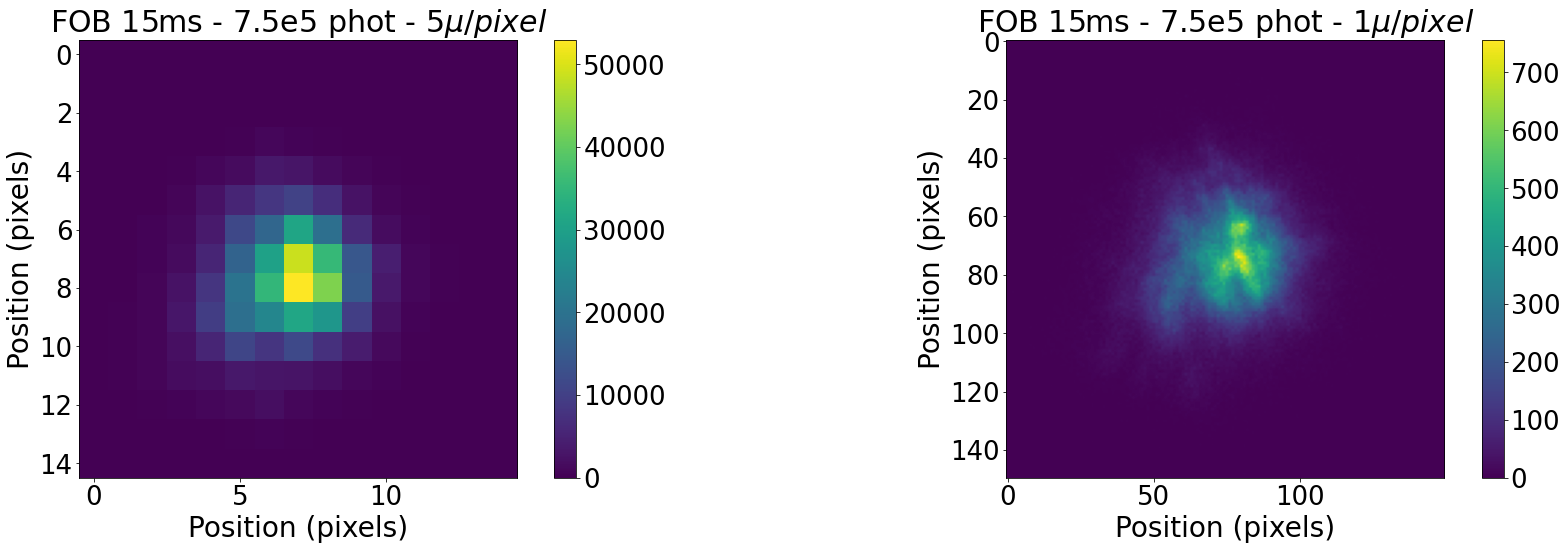

In [7]:
%%time 
rng = galsim.BaseDeviate(53)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            diam = 8.36,
            t0 = 0,
            exptime = 0.015, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 7.5e5 phot')

frb_photons = frb_total_psf.shoot(int(1e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 1e5 phot')

frb_photons = frb_total_psf.shoot(int(8e4), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 8e4 phot')

frb_photons = frb_total_psf.shoot(int(6e4), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 6e4 phot')

frb_photons = frb_total_psf.shoot(int(4e4), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 4e4 phot')

frb_photons = frb_total_psf.shoot(int(2e4), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 2e4 phot')

frb_photons = frb_total_psf.shoot(int(1e4), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FOB 15ms - 1e4 phot')


## 2. PSFs

In this section we generate the PSFs corresponding to the galaxy (15 s exposure) and the FRB (5 ms exposure) through the atmosphere. We plot them at the end of the section. 


### 2.1 Star + Atmospheric PSF

Generate the PSF corresponding to a Star point source convoltued with the atmosphere screens integrated during a 15s exposure. Once the psf is generated, in the next section we shoot photons through it to generate the image we would obtain through the atmosphere before going into the detector. 

### Star with Geometric Approx.

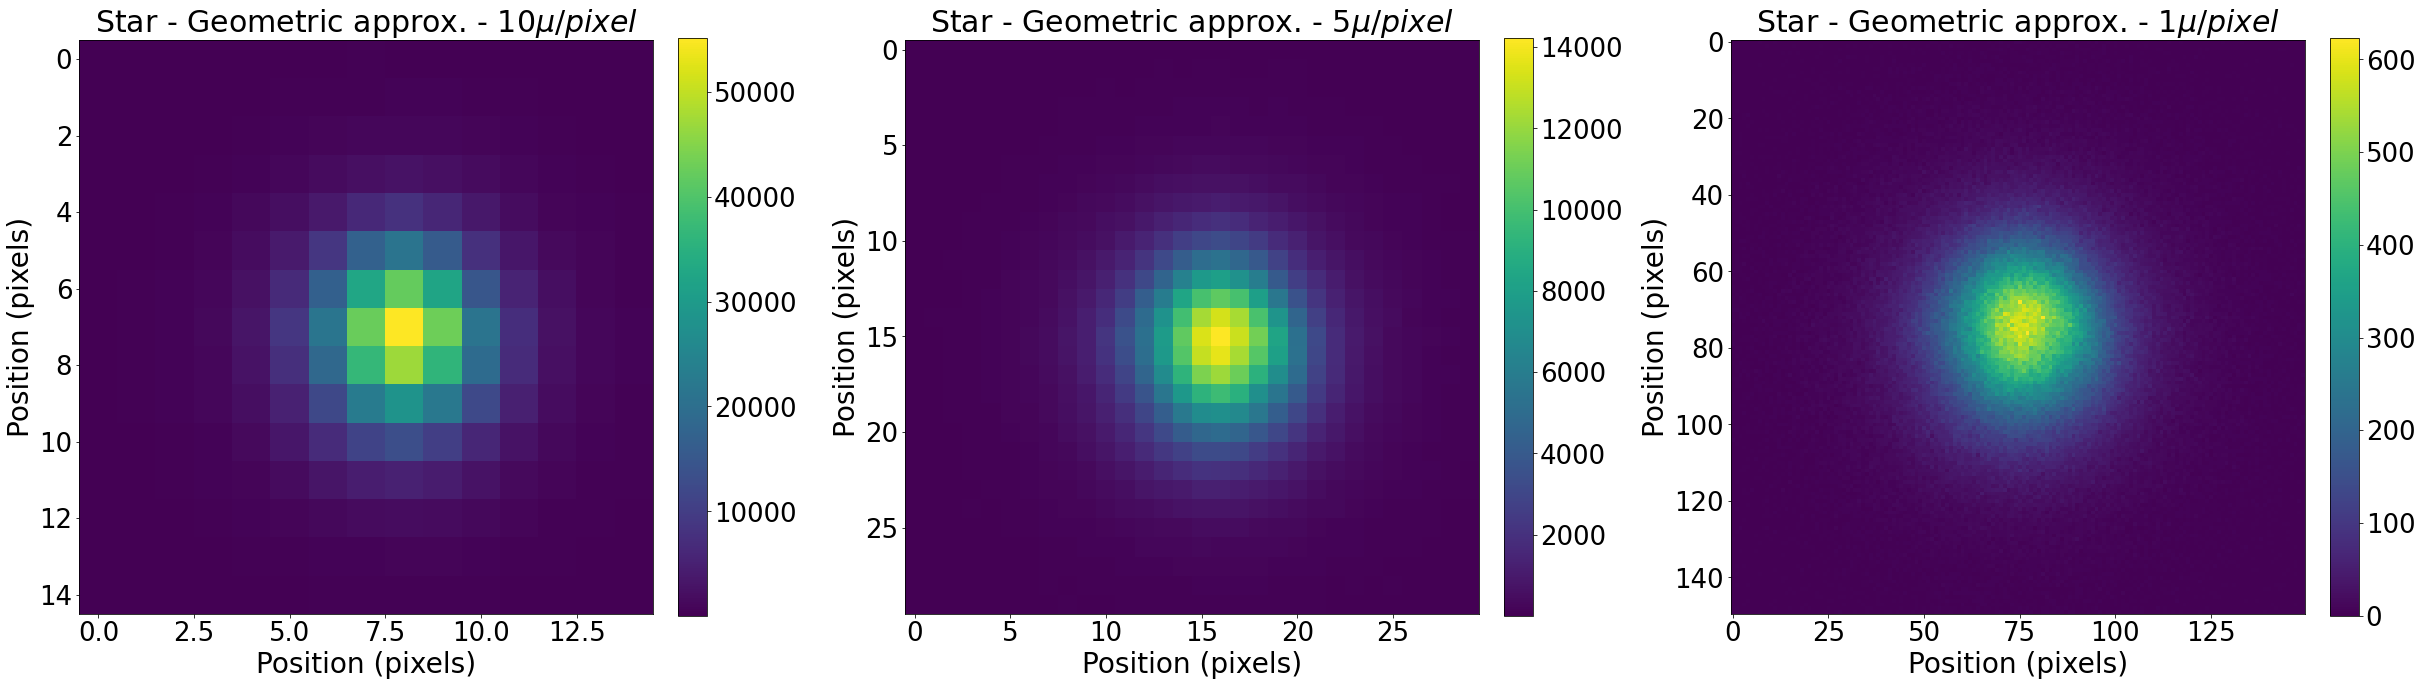

In [5]:
# Define point-source as a delta function profile
star_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
star_atm_psf = truncated_atm.makePSF(
            wavelength, 
            t0 = 0,
            diam = 8.36,
            exptime = 15.0,
            obscuration = 0.61
        )

# Convolve with point-source psf
star_total_psf = galsim.Convolve([star_delta, star_atm_psf.second_kick])

# Shoot photons through star and atmsosphere second kick.
star_photons = star_total_psf.shoot(int(1e6), rng)

traced_photons, wavelengths = trace.tracePhotons(star_photons, rng, observation, wavelength, truncated_atm, first_kick = True)

plot_results(traced_photons, 'Star - Geometric approx.')


CPU times: user 7.85 s, sys: 470 ms, total: 8.32 s
Wall time: 4.48 s


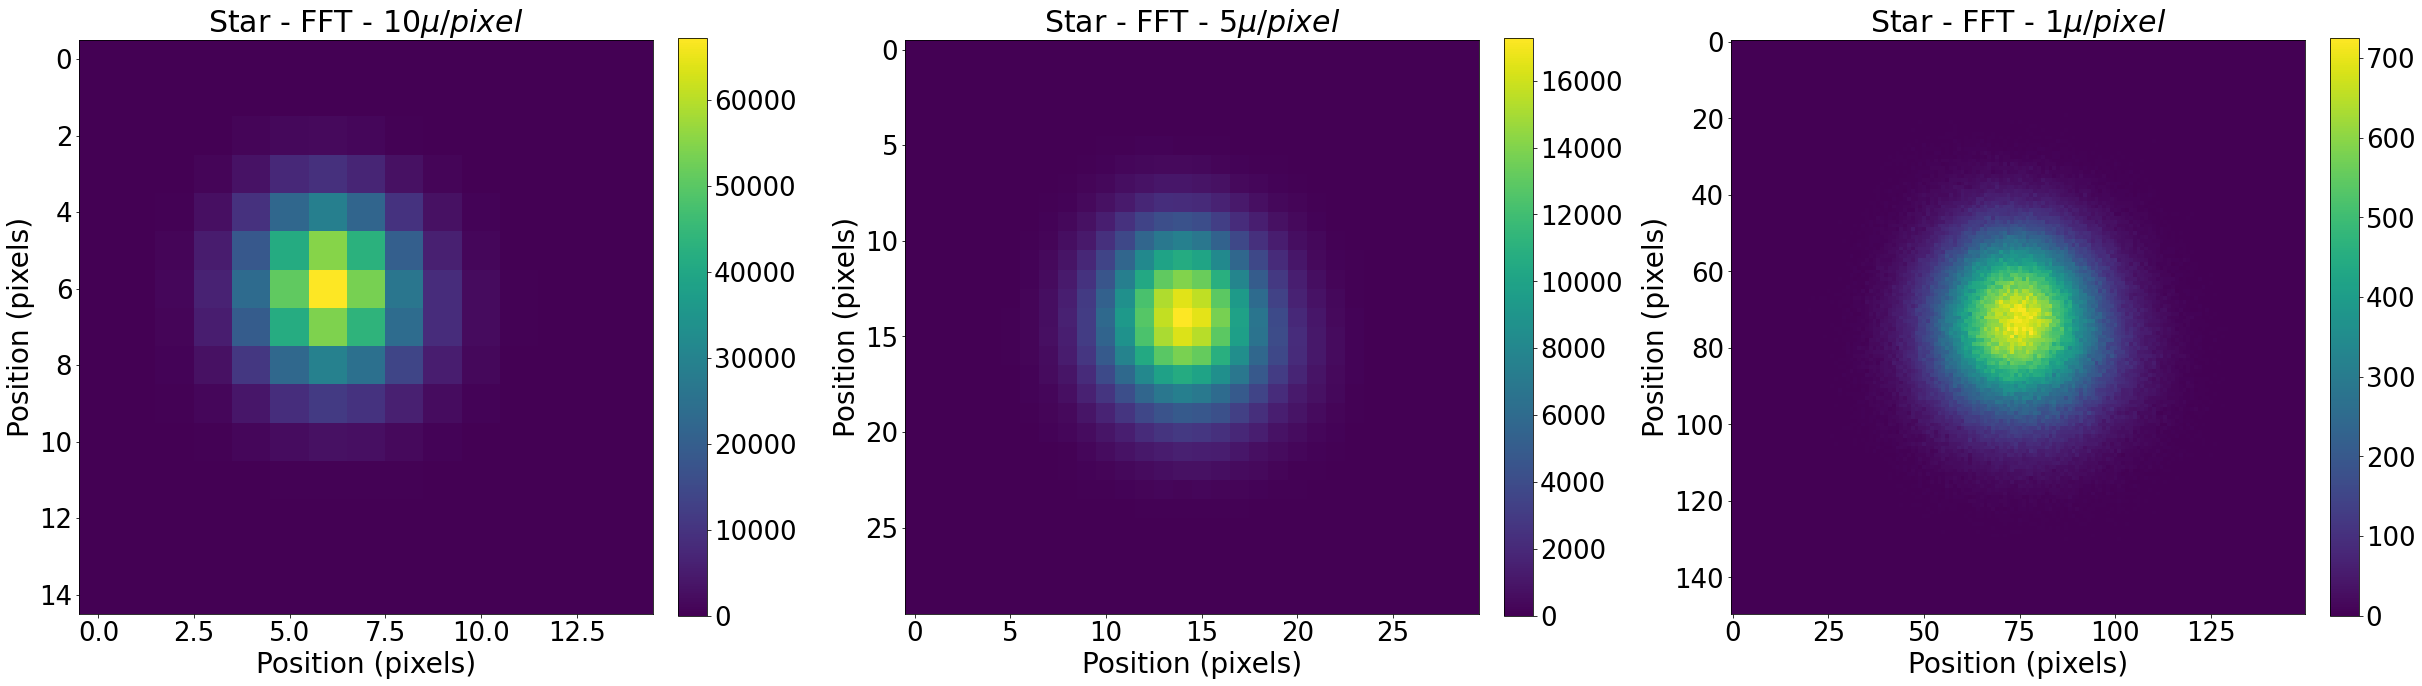

In [6]:
%%time
# Define point-source as a delta function profile
star_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
star_atm_psf = full_atm.makePSF(
                            wavelength, 
                            t0=0, 
                            exptime=15.0, 
                            diam=8.36, 
                            obscuration=0.61,
                            geometric_shooting = False,
                            second_kick = False,
                        )

# Convolve with point-source psf
star_total_psf = star_delta

# Shoot photons through star and atmsosphere second kick.
star_photons = star_total_psf.shoot(int(1e6), rng)

traced_photons, wavelengths = trace.tracePhotons(star_photons, rng, observation, wavelength, full_atm, first_kick = True)

plot_results(traced_photons, 'Star - FFT')

### 2.2 Initialization of FRB

Generate the PSF corresponding to the FRB. Once generated the PSF, we shoot photons that will be used to for atmospheric tracing. 

### FRB - FFT 

682849.2078781128
CPU times: user 12.1 s, sys: 317 ms, total: 12.4 s
Wall time: 8.24 s


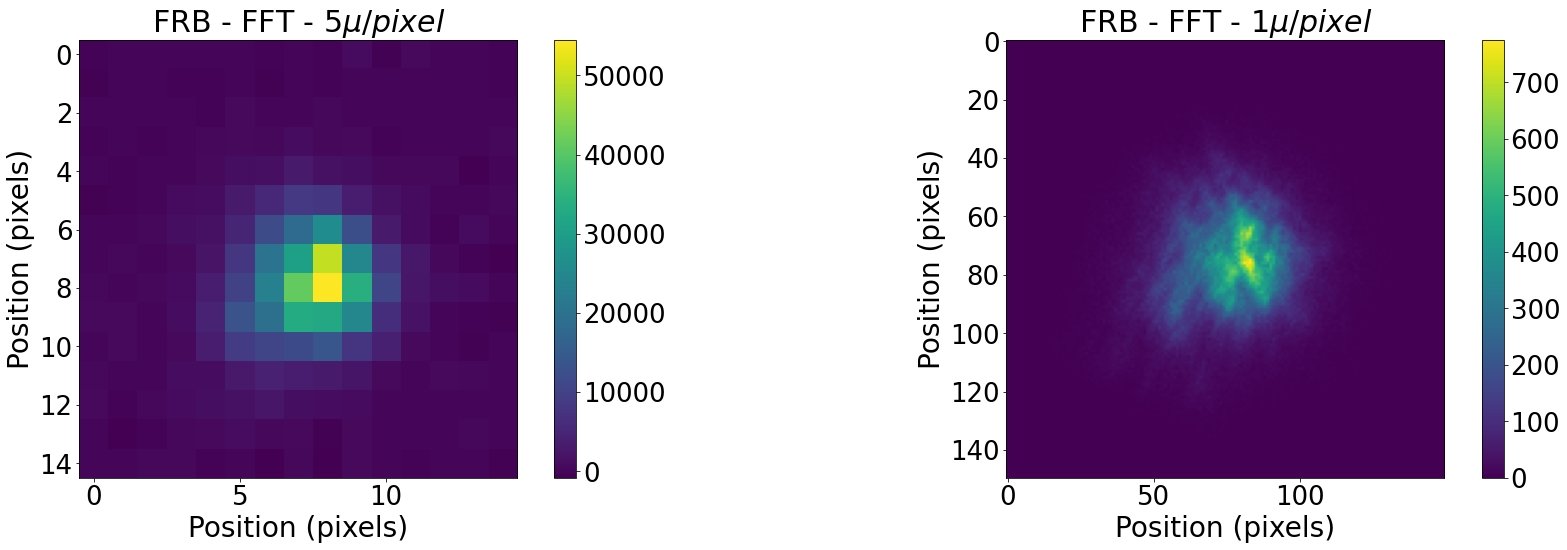

In [7]:
%%time 
rng = galsim.BaseDeviate(53)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FRB - FFT')

In [17]:
np.random.random()*100

20.52689481162966

CPU times: user 12.3 s, sys: 345 ms, total: 12.6 s
Wall time: 9.58 s


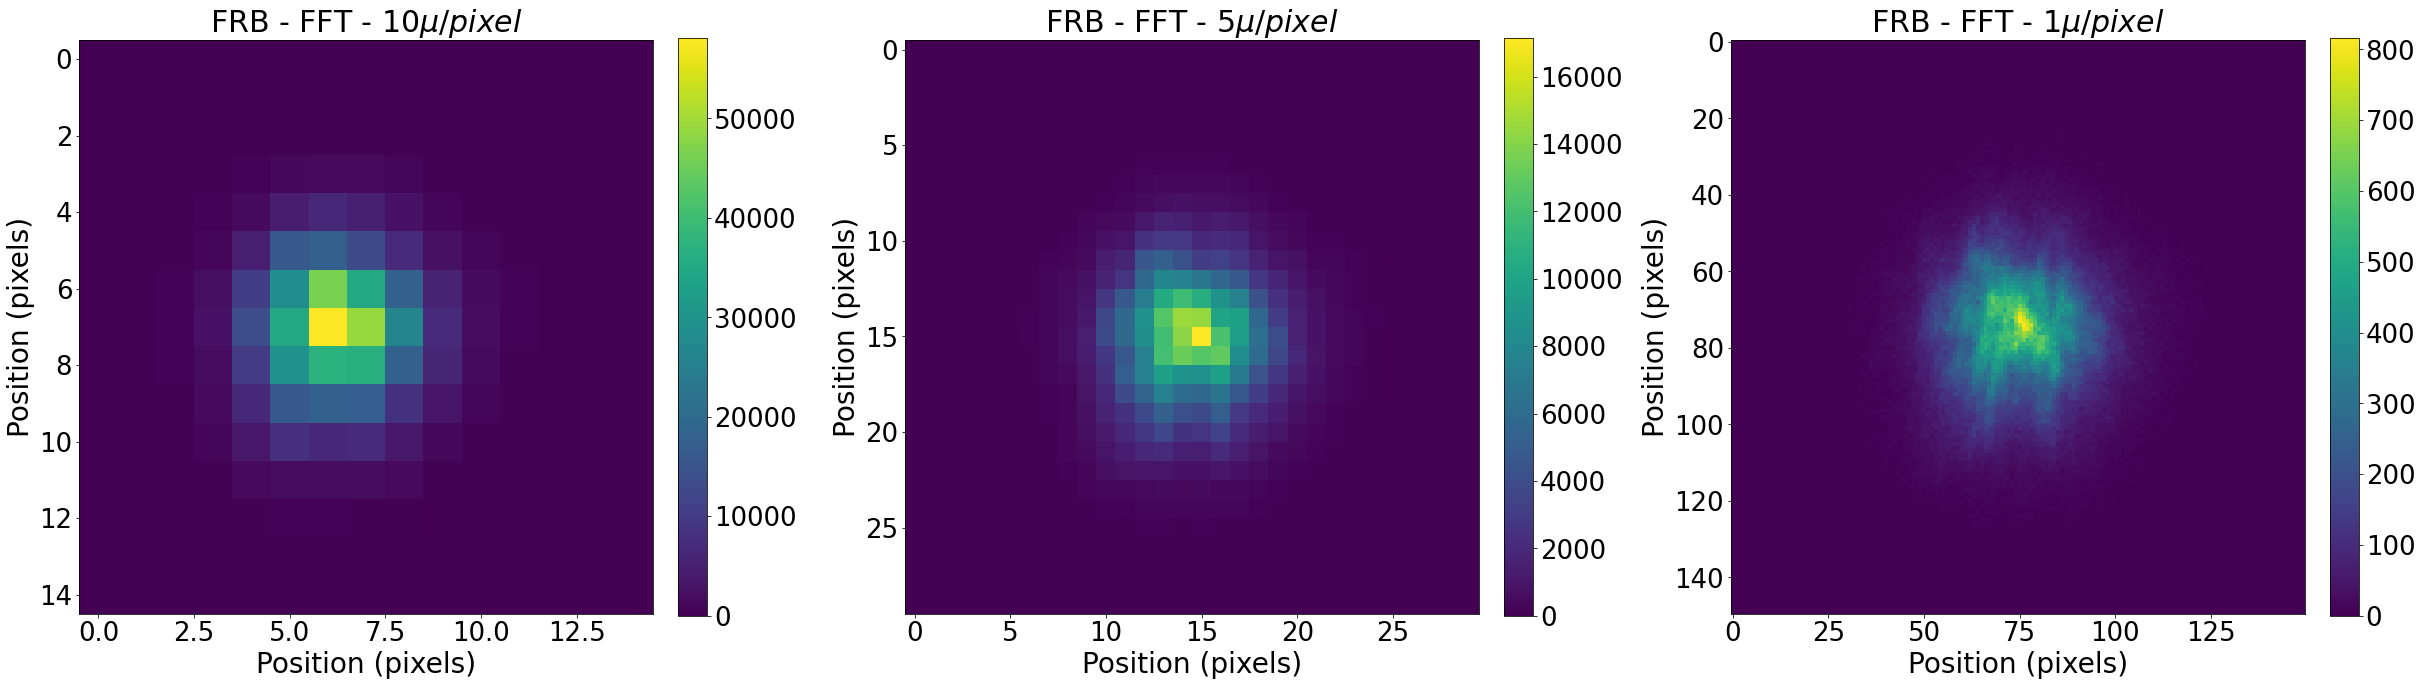

In [21]:
%%time
rng = galsim.BaseDeviate(53)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            t0=np.random.random()*100,
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_atm_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FRB - FFT')

### FRB - Geometric approx

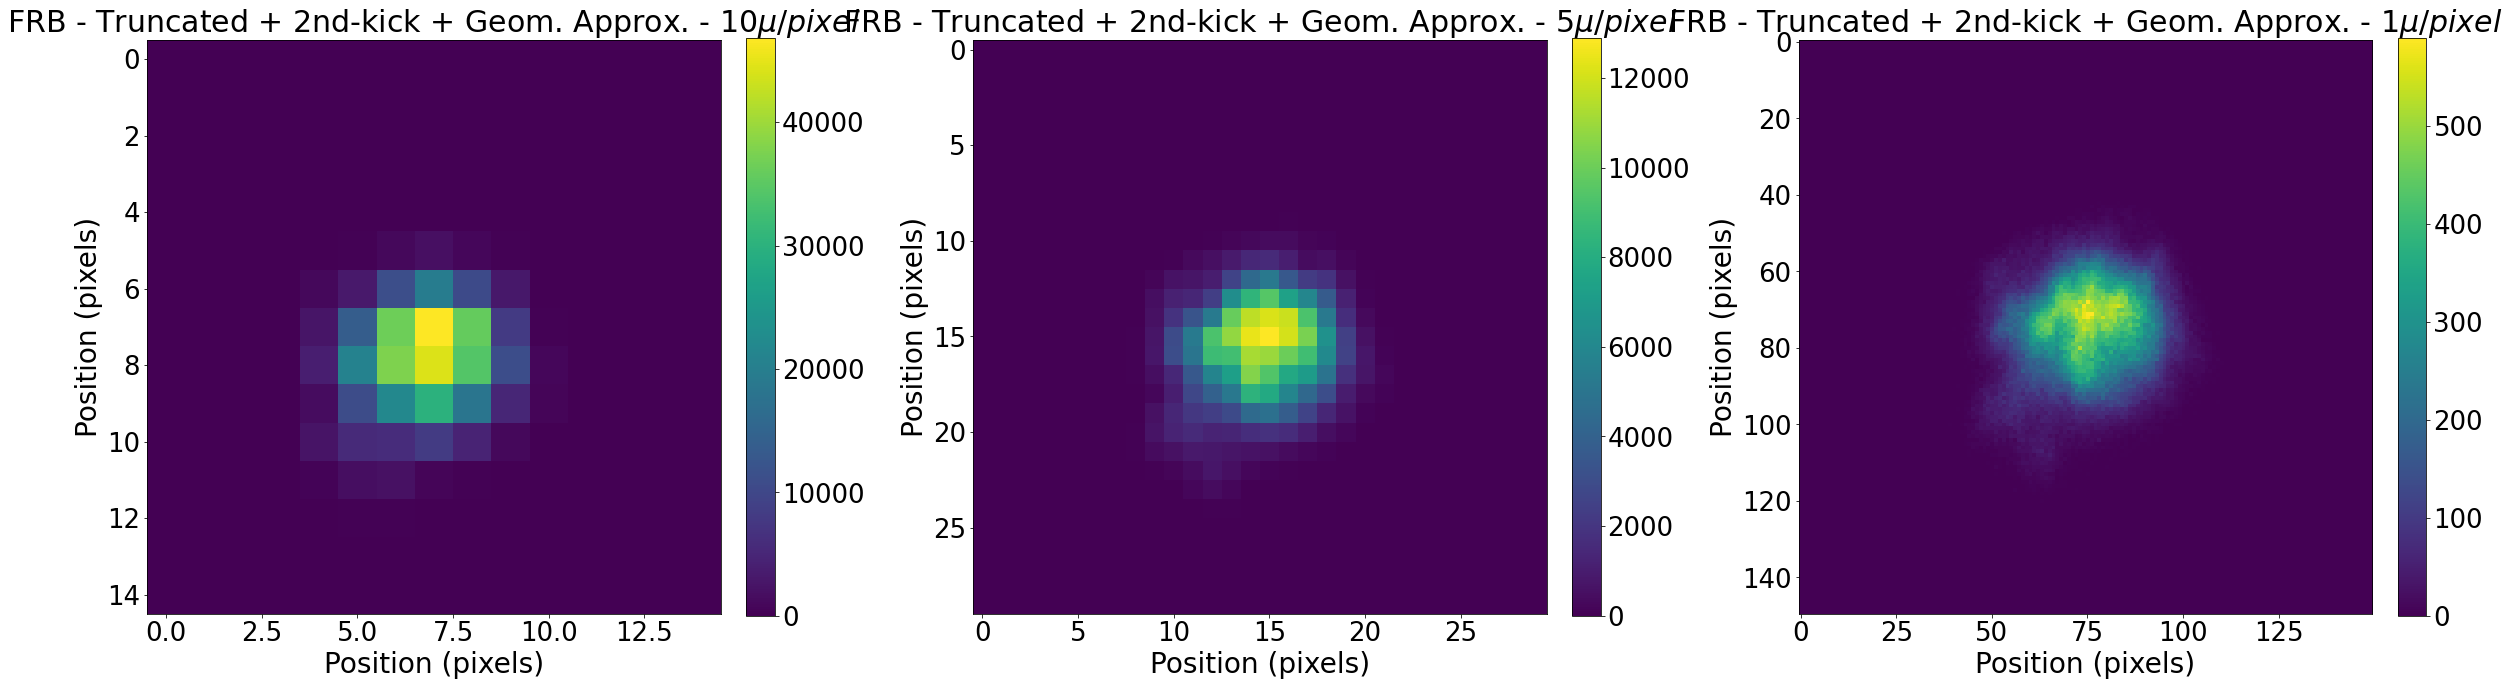

In [10]:
# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = truncated_atm.makePSF(
            wavelength, 
            t0 = 0.292,
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0,
            geometric_shooting = True,
            second_kick = False,
        )

# Convolve with point-source psf

frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, truncated_atm, first_kick = False)

plot_results(traced_photons, 'FRB - Truncated + 2nd-kick + Geom. Approx.')

/opt/conda/lib/python3.7/site-packages/galsim/errors.py:419: GalSimWarning: AtmosphericScreen was instantiated for photon shooting. Drawing now with FFT may yield surprising results.
  warnings.warn(message, GalSimWarning)


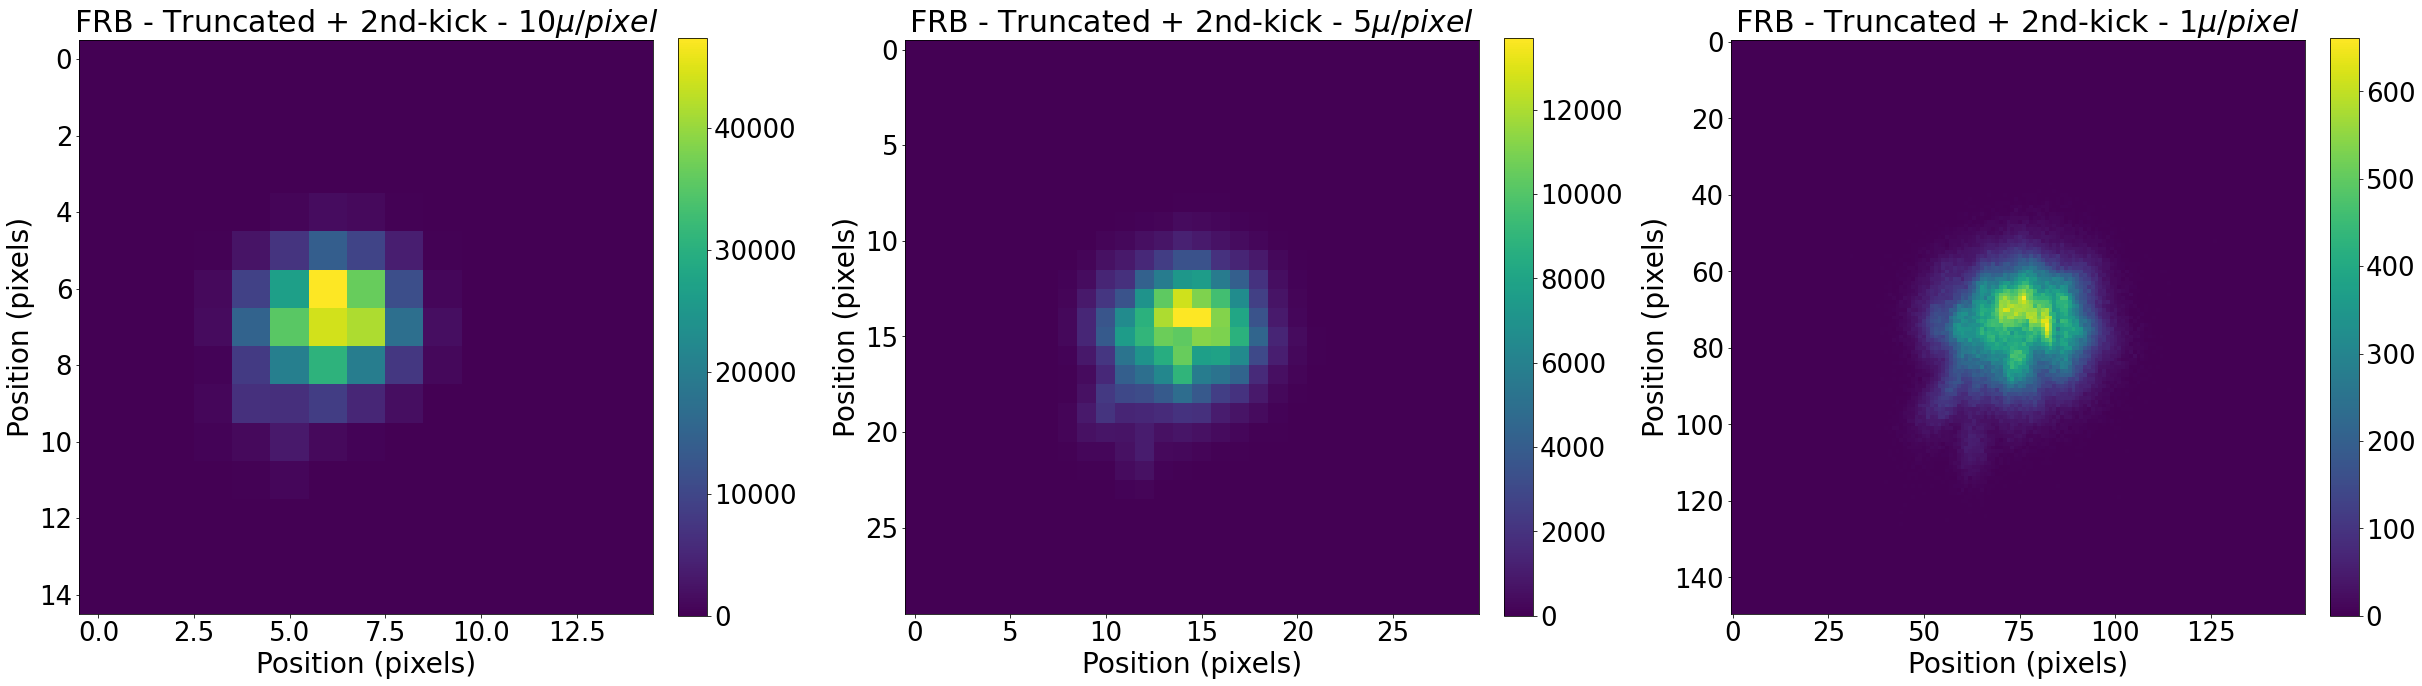

In [11]:
# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = truncated_atm.makePSF(
            wavelength, 
            t0=0.292, 
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0,
            geometric_shooting = False,
            second_kick = True,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, truncated_atm, first_kick = False)

plot_results(traced_photons, 'FRB - Truncated + 2nd-kick')



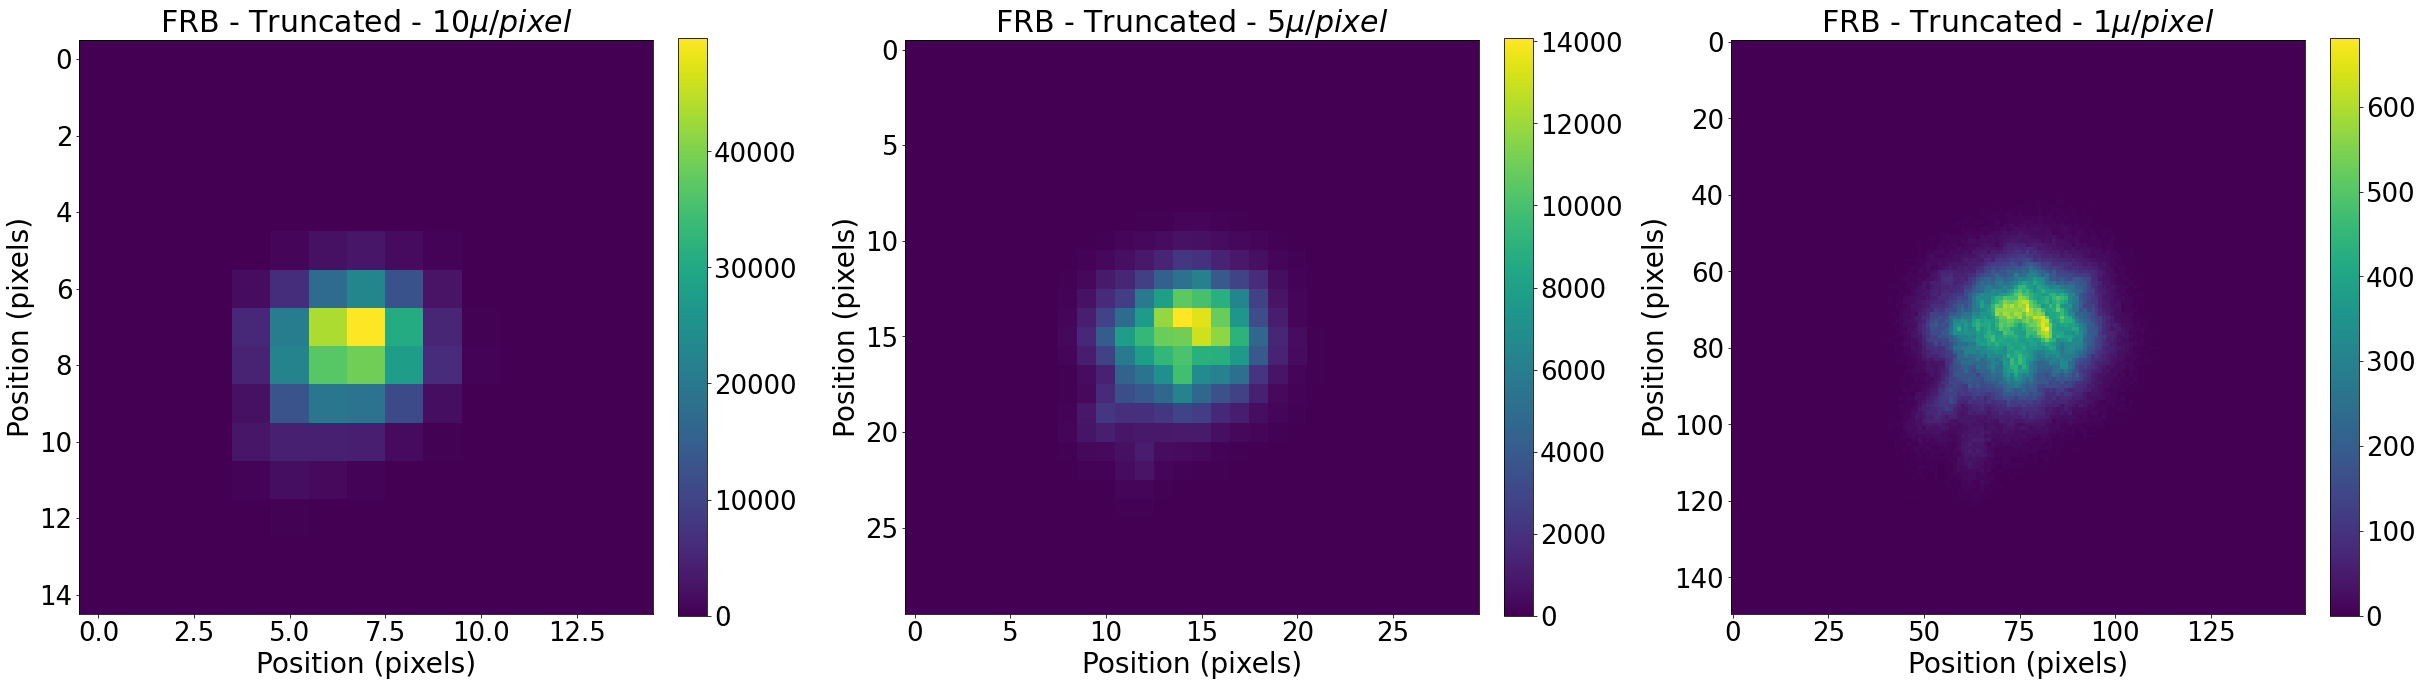

In [12]:
# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = truncated_atm.makePSF(
            wavelength, 
            t0=0.292, 
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0,
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_total_psf.shoot(int(5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, truncated_atm, first_kick = False)

plot_results(traced_photons, 'FRB - Truncated')

### Comparison DFT and photon-shooting

CPU times: user 28.5 s, sys: 693 ms, total: 29.2 s
Wall time: 25.2 s


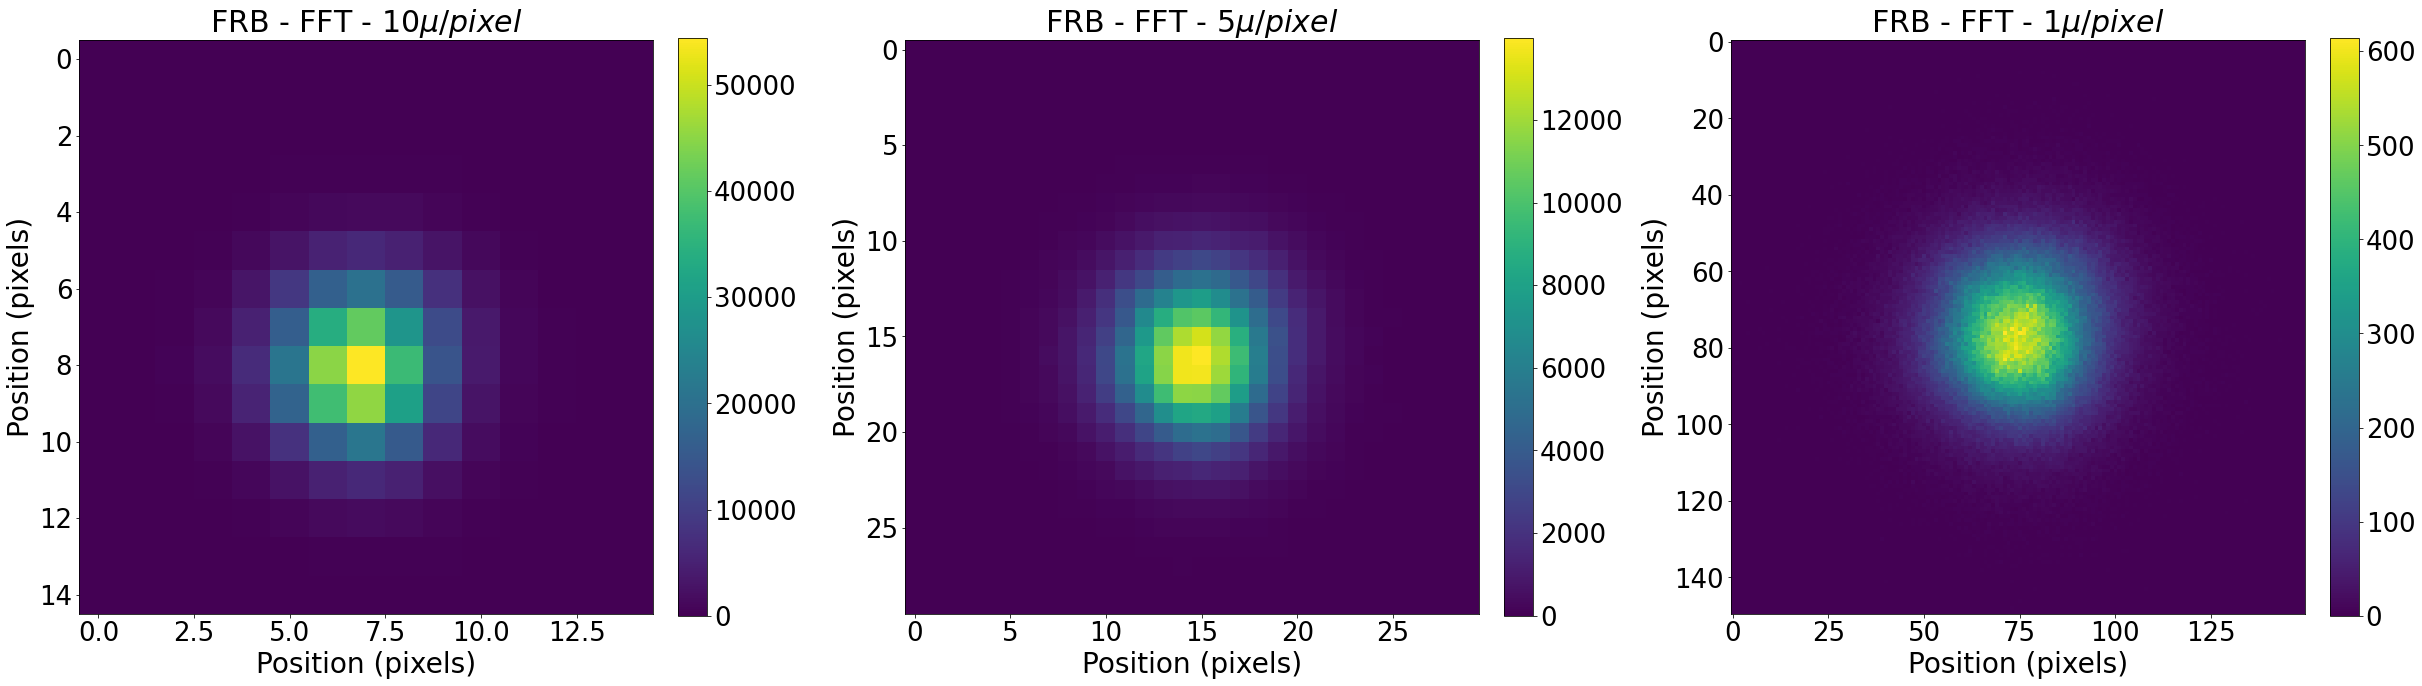

In [15]:
%%time
rng = galsim.BaseDeviate(53)

# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = full_atm.makePSF(
            wavelength, 
            t0=0.292, 
            diam = 8.36,
            exptime = 1.5, 
            flux = 1.0, 
            geometric_shooting = False,
            second_kick = False,
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_atm_psf.shoot(int(7.5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

plot_results(traced_photons, 'FRB - FFT')

In [ ]:
%%time
 # Full Fourier-optics simulation for FRB (short exptime)
frb_fft_psf = full_atm.makePSF(725, t0=0, exptime=1.5, diam=8.36, obscuration=0.61)
frb_fft_img = frb_fft_psf.drawImage(**kwargs)

# Geometric approximations use the truncated atmospheres
frb_geom_psf = truncated_atm.makePSF(725, t0=0, exptime=0.0015, diam=8.36, obscuration=0.61)
frb_geom_img = frb_geom_psf.drawImage(**kwargs, method='phot', n_photons=100_000)    

star_geom_psf = truncated_atm.makePSF(725, t0=0, exptime=15.0, diam=8.36, obscuration=0.61)
star_geom_img = star_geom_psf.drawImage(**kwargs, method='phot', n_photons=100_000)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].imshow(frb_fft_img.array)
axes[0,0].set_title("FRB FFT")
axes[0,1].imshow(star_fft_img.array)
axes[0,1].set_title("star FFT")
axes[1,0].imshow(frb_geom_img.array)
axes[1,0].set_title("FRB geom")
axes[1,1].imshow(star_geom_img.array)
axes[1,1].set_title("star geom")
plt.tight_layout()
plt.show()

### FRB Truncated atmosphere - no second-kick

Text(0.5, 1.0, 'FRB - Geometric Approx.')

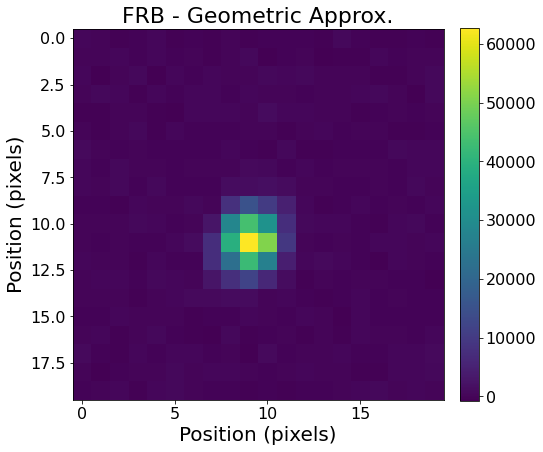

In [47]:
# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
frb_atm_psf = truncated_atm.makePSF(
            wavelength, 
            diam = 8.36,
            exptime = 0.015, 
            flux = 1.0,
            geometric_shooting = True,
            second_kick = False
        )

# Convolve with point-source psf
frb_total_psf = galsim.Convolve([frb_delta, frb_atm_psf])

frb_photons = frb_atm_psf.shoot(int(5e5), rng)

traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, truncated_atm, first_kick = False)

frb_array = printSensorImage(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 20, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = True,
)

plt.title('FRB - Geometric Approx.', fontsize = 22)

## 3. Telescope tracing

In this section we trace the photons through the telescope up until the detector, thus simulating the final image we would retrieve, were we to observe the simulated galaxy. We obtain an image with the FRB and an image without. 

Text(0.5, 1.0, 'Observed FRB - No Second-kick')

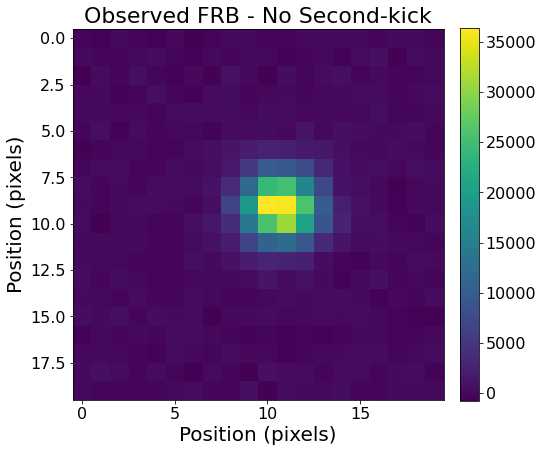

In [15]:
traced_photons, wavelengths = trace.tracePhotons(frb_photons, rng, observation, wavelength, full_atm, first_kick = False)

frb_array = printSensorImage(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 20, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = True,
)

plt.title('Observed FRB - No Second-kick', fontsize = 22)

Text(0.5, 1.0, 'Observed FRB - Second Kick')

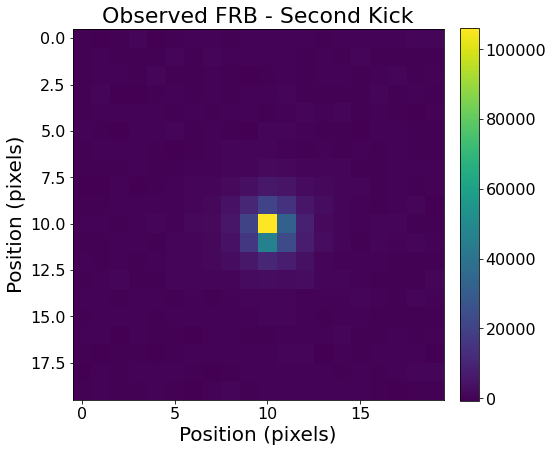

In [16]:
traced_photons, wavelengths = trace.tracePhotons(frb_photons_tr, rng, observation, wavelength, truncated_atm, first_kick = False)

frb_array = printSensorImage(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 20, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = True,
)

plt.title('Observed FRB - Second Kick', fontsize = 22)

Text(0.5, 1.0, 'Observed Point-source')

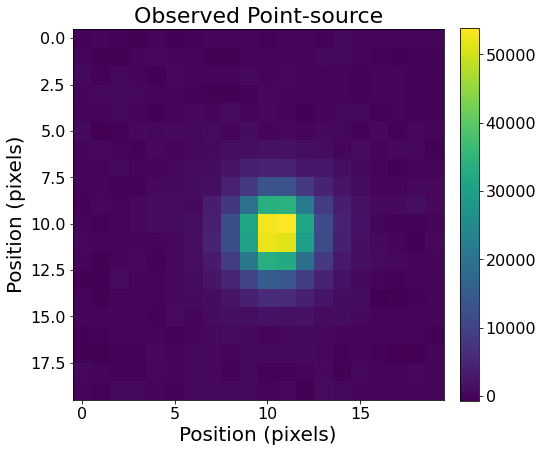

In [17]:
traced_photons, wavelengths = trace.tracePhotons(star_photons, rng, observation, wavelength, atm, first_kick = True)

star_array = printSensorImage(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 20, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = True,
)


plt.title('Observed Point-source', fontsize = 22)

Text(0.5, 1.0, 'Observed Point-source')

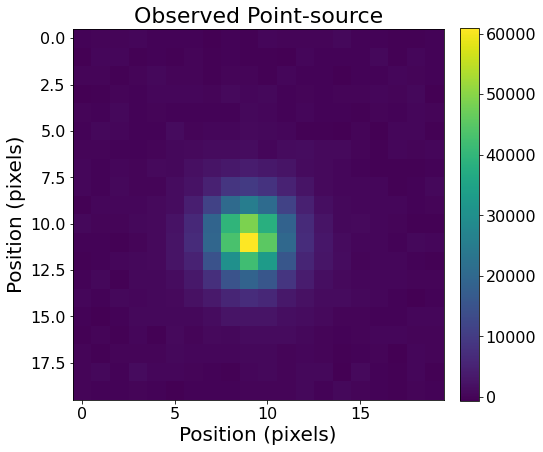

In [34]:
star_array = printSensorImage(
    traced_photons, 
    wavelengths, 
    STAMP_SIZE = 20, 
    PIXEL_SIZE = 10e-6,
    SKY_LEVEL = 1000.0,
    noise = True,
)

name = 'pointsource'

for iter in tqdm()range(50):
    traced_photons, wavelengths = trace.tracePhotons(star_photons, rng, observation, wavelength, atm, first_kick = True)
    star_array = printSensorImage(
        traced_photons, 
        wavelengths, 
        STAMP_SIZE = 20, 
        PIXEL_SIZE = 10e-6,
        SKY_LEVEL = 1000.0,
        noise = True,
    )
    cv2.imwrite('{}_{}.jpeg'.format(name, it), star_array)
    plt.imsave('{}_{}.png'.format(name, it), star_array)
    np.save('{}_{}'.format(name, it), star_array)
    np.savetxt('{}_{}.txt'.format(name, it), star_array, delimiter=',')

plt.title('Observed Point-source', fontsize = 22)

In [31]:
frb_moments = cv2.moments(frb_array)

print('Intensity of image is {}'.format(frb_moments['m00']))
print('Skewness of image is ({},{})'.format(frb_moments['nu03'], frb_moments['nu30']))
print('Variance of image is ({},{})'.format(frb_moments['mu02'], frb_moments['mu20']))

star_moments = cv2.moments(star_array)

print('Intensity of image is {}'.format(star_moments['m00']))
print('Skewness of image is ({},{})'.format(star_moments['nu03'], star_moments['nu30']))
print('Variance of image is ({},{})'.format(star_moments['mu02'], star_moments['mu20']))

Intensity of image is 13626.0
Skewness of image is (-2.9040260409951672e-06,-8.074714677916146e-07)
Variance of image is (56891.18949067965,63676.92793189548)
Intensity of image is 134051.0
Skewness of image is (6.380330981839461e-09,-3.675140904613804e-08)
Variance of image is (1847618.8963752538,1842286.2591849267)
